In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wednesday May 10 10:11:42 2023
Example Code for optimizing spiral trajectory jointly with Image Deep Artifact Suppression network (FastDVDnet) for interactive MRI

Methods details in : 
HyperSLICE: HyperBand optimised Spiral for Low-latency Interactive Cardiac Examination, (2023)

Trained from flower image dataset.
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

@author: Dr. Olivier Jaubert
"""

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import numpy as np
import tensorflow as tf
try:
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    print('running on CPU')
import tensorflow_mri as tfmri
import random
import matplotlib.pyplot as plt
import datetime
import pathlib
import keras_tuner as kt

import model.hypermodel as hypermodel
# Local imports (works if you are in project folder)
import model.layers as layers
import utils.preprocessing_natural_images as preproc_filename_2_kspace
import utils.preprocessing_trajectory_gen as preproc_traj
import utils.preprocessing_fastdvdnet_noselect as preproc_fastdvdnet
import utils.preprocessing_rolling_fastdvdnet as preproc_roll
import utils.display_function_fastdvdnet as display_func


#Set seed for all packages
seed_value=1
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
;

''

In [2]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)
data_dir = pathlib.Path(archive).with_suffix('')

In [3]:
#Configuration
DEBUG=True
learning_rate=0.0001

config_traj=preproc_traj.config_optimized_traj()
config_preproc=preproc_fastdvdnet.config_base_preproc()
config_natural_images={'base_resolution':config_preproc['base_resolution'],'phases':config_preproc['phases'],'num_coils':10,'addmotion':1}

config={'experiment_path': 'HyperBand_folder',
        'experiment_name': 'Test_FastDVDnet',
        'split' : [0.7,0.15,0.15], #train, val, test
        'split_mode': 'noshuffle', #noshuffle or random
        'learning_rate': learning_rate,
        'optimizer': tf.keras.optimizers.Adam(learning_rate=learning_rate,clipnorm=1),
        'epochs':200,
        'loss': tfmri.losses.StructuralSimilarityLoss(rank=2),
        'metrics':[tfmri.metrics.PeakSignalToNoiseRatio(rank=2),
                   tfmri.metrics.StructuralSimilarity(rank=2)]}

imshape=(config_preproc['phases'],config_preproc['base_resolution'],config_preproc['base_resolution'])

config_model={'scales': 3,
      'block_depth': 2,
      'base_filters': 32,
      'kernel_size': 3,
      'use_deconv': 'PixelShuffle',
      'rank': 2,
      'activation': tf.keras.activations.relu,
      'out_channels': 1,
      'kernel_initializer': tf.keras.initializers.HeUniform(seed=1),
      'time_distributed': False}

In [4]:
# Read files and split data 
train_files=[]
val_files=[]
test_files=[]
sorted_files=[x for x in sorted(list(map(str,data_dir.glob('roses/*'))))]
if DEBUG:
      n=20
else:
      n=len(sorted_files); 
ntrain=int(config['split'][0]*n); nval=int(config['split'][1]*n); ntest=int(np.ceil(config['split'][2]*n))

train_files=sorted_files[:ntrain]
val_files=sorted_files[ntrain:ntrain+nval]
test_files=sorted_files[ntrain+nval:ntrain+nval+ntest]

# Shuffle files.
random.shuffle(train_files)
random.shuffle(val_files)
random.shuffle(test_files)

print('Total/Train/Val/Test:',len(train_files)+len(val_files)+len(test_files),
      '/',len(train_files),'/',len(val_files),'/',len(test_files),'leftovers:',n-ntrain-nval-ntest)

Total/Train/Val/Test: 20 / 14 / 3 / 3 leftovers: 0


(-0.5, 1439.5, 239.5, -0.5)

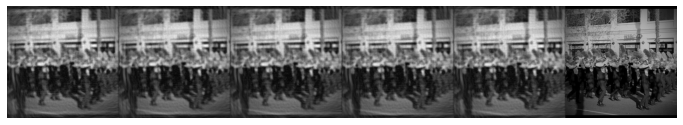

In [5]:
#Define Preprocessing run once to get input shapes
preproc_natural_image=preproc_filename_2_kspace.preprocessing_fn(**config_natural_images)
traj_function=preproc_traj.create_traj_fn(**config_traj)
preproc_function=preproc_fastdvdnet.preprocessing_fn(**config_preproc)
roll_function=preproc_roll.preprocessing_fn()
# Run Preprocessing once on case [0]
kspace=preproc_natural_image(train_files[1])
ds=tf.data.Dataset.from_tensors(kspace)
image=traj_function(ds)
for element in image:
  inputs_temp,gt_temp=preproc_function(element)
  inputs,gt=roll_function(inputs_temp,gt_temp)
plt.figure(figsize=(12,3))
plt.imshow(np.abs(np.concatenate((inputs[:,:,0],inputs[:,:,1],inputs[:,:,2],inputs[:,:,3],inputs[:,:,4],gt[:,:,0]),axis=1)),cmap='gray')
plt.axis('off')

In [6]:
#Creating Tensorflow dataset
# Create datasets.
datasets=[train_files,val_files,test_files]
prepdatasets=[]
for pp,dataset in enumerate(datasets):
    dataset = tf.data.Dataset.from_tensor_slices(
        tf.convert_to_tensor(list(map(str, dataset)), dtype=tf.string))
    dataset=dataset.map(preproc_natural_image,num_parallel_calls=1)
    prepdatasets.append(dataset)

In [7]:
#Define hyperparameters
config_traj['ordering']=['tiny','linear']
config_traj['vd_spiral_arms']=[12,24]
config_traj['vd_inner_cutoff']=[0.1,0.4]
config_traj['pre_vd_outer_cutoff']=[0.01,1.0]
config_traj['vd_outer_density']=[0.01,0.35]
config_traj['vd_type']=['linear','hanning','quadratic']

In [8]:
#HyperModel FastDVDnet
config_traj_hp=config_traj
hpmodel=hypermodel.HyperModelFastDVDnet(config_model,
                    inputs.shape,
                    optimizer=config['optimizer'],
                    loss=config['loss'],
                    metrics=config['metrics'],name='HM', tunable=True)
#model=hpmodel.build( _ )
# hpmodel.fit( _, model, exp_dir, prepdatasets,config_preproc,config_traj)

#Define Hyperparameters outside for HyperBand
hp = kt.HyperParameters()
hp.Choice('ordering',config_traj['ordering'])
hp.Int('vd_spiral_arms',config_traj['vd_spiral_arms'][0],config_traj['vd_spiral_arms'][1])
hp.Float('vdi',config_traj['vd_inner_cutoff'][0],config_traj['vd_inner_cutoff'][1])
hp.Float('pre_vdo',config_traj['pre_vd_outer_cutoff'][0],config_traj['pre_vd_outer_cutoff'][1])
hp.Float('outer_den',config_traj['vd_outer_density'][0],config_traj['vd_outer_density'][1])
hp.Choice('vd_type',['linear','hanning','quadratic'])

if DEBUG:
    # tuner = kt.RandomSearch(
    #     objective=kt.Objective('val_loss', "min"),
    #     max_trials=5,
    #     hypermodel=hpmodel,
    #     directory="results",
    #     project_name="custom_training",
    #     overwrite=True,
    # )
    max_epochs=5
    tuner = kt.Hyperband(
        hypermodel=hpmodel,
        objective=kt.Objective('val_loss', "min"),
        max_epochs=max_epochs,
        factor=3,
        hyperband_iterations=1,
        directory="results2",
        project_name="debug_hyperband",
        overwrite=True,
        seed=0,
        hyperparameters=hp,
    )
else:
    max_epochs=150
    tuner = kt.Hyperband(
        objective=kt.Objective('val_loss', "min"),
        factor=5,
        hyperband_iterations=1,
        max_epochs=max_epochs,
        hypermodel=hpmodel,
        directory="results2",
        project_name="hyperband",
        overwrite=True,
        hyperparameters=hp,
        seed=0,
    )


In [9]:
#Launch HyperParameter optimisation
callbacks=[]
tuner.search(prepdatasets,config_preproc,config_traj,callbacks=callbacks)


Trial 10 Complete [00h 00m 14s]
val_loss: 0.20685738325119019

Best val_loss So Far: 0.20685738325119019
Total elapsed time: 00h 02m 07s
INFO:tensorflow:Oracle triggered exit


In [10]:
#Retrain Best model
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()
best_model = tuner.load_model(best_trial)

path = config['experiment_path']
exp_name = os.path.splitext(os.path.basename(config['experiment_name']))[0]
exp_name += '_' + datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
exp_dir = os.path.join(path, exp_name)

print(exp_dir)
callbacks=[]
checkpoint_filepath=os.path.join(exp_dir,'ckpt/saved_model')
callbacks.append(tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_loss',
        mode='min',
        save_weights_only=False,
        save_best_only=True))
callbacks.append(tf.keras.callbacks.TensorBoard(log_dir=os.path.join(exp_dir,'logs')))

print(best_hps.values)
model = tuner.hypermodel.build(best_hps)
history = hpmodel.fit(best_hps,model, prepdatasets,config_preproc,config_traj,callbacks=callbacks,epochs=np.max(50,max_epochs))

Trial summary
Hyperparameters:
ordering: tiny
vd_spiral_arms: 18
vdi: 0.27923741114945233
pre_vdo: 0.11173513421559131
outer_den: 0.28365011341910457
vd_type: hanning
tuner/epochs: 5
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.20685738325119019
HyperBand_folder/Test_FastDVDnet_20231116_182344
{'ordering': 'tiny', 'vd_spiral_arms': 18, 'vdi': 0.27923741114945233, 'pre_vdo': 0.11173513421559131, 'outer_den': 0.28365011341910457, 'vd_type': 'hanning', 'tuner/epochs': 5, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
Traj params: {'flow': 0, 'base_resolution': 240, 'field_of_view': 400, 'phases': 12, 'ordering': 'tiny', 'max_tempres': 55, 'min_max_arm_time': [0.88, 1.67], 'vd_spiral_arms': 18, 'vd_inner_cutoff': 0.27923741114945233, 'pre_vd_outer_cutoff': 0.11173513421559131, 'vd_outer_density': 0.28365011341910457, 'vd_type': 'hanning', 'max_grad_ampl': 22.0, 'min_rise_time': 10.0, 'dwell_time': 1.4, 'gradient_delay': 0.56, 'readoutOS': 2.0, 'deadtime'

INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231116_182344/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231116_182344/ckpt/saved_model/assets


14/14 [==============================] - 10s 443ms/step - loss: 0.8109 - psnr: 14.8414 - ssim: 0.2926 - val_loss: 0.5600 - val_psnr: 18.6954 - val_ssim: 0.4400
Epoch 2/50
14/14 [==============================] - ETA: 0s - loss: 0.4890 - psnr: 18.9045 - ssim: 0.5110WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f00506d5bb0>, because it is not built.


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231116_182344/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231116_182344/ckpt/saved_model/assets


14/14 [==============================] - 3s 242ms/step - loss: 0.4890 - psnr: 18.9045 - ssim: 0.5110 - val_loss: 0.3362 - val_psnr: 22.2789 - val_ssim: 0.6638
Epoch 3/50
14/14 [==============================] - ETA: 0s - loss: 0.3860 - psnr: 19.8137 - ssim: 0.6140WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f00506d5bb0>, because it is not built.


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231116_182344/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231116_182344/ckpt/saved_model/assets


14/14 [==============================] - 3s 239ms/step - loss: 0.3860 - psnr: 19.8137 - ssim: 0.6140 - val_loss: 0.2892 - val_psnr: 17.9110 - val_ssim: 0.7108
Epoch 4/50
14/14 [==============================] - ETA: 0s - loss: 0.3769 - psnr: 19.4046 - ssim: 0.6231WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f00506d5bb0>, because it is not built.


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231116_182344/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231116_182344/ckpt/saved_model/assets


14/14 [==============================] - 3s 227ms/step - loss: 0.3769 - psnr: 19.4046 - ssim: 0.6231 - val_loss: 0.2700 - val_psnr: 22.6264 - val_ssim: 0.7300
Epoch 5/50
14/14 [==============================] - 1s 73ms/step - loss: 0.3565 - psnr: 18.6228 - ssim: 0.6435 - val_loss: 0.3017 - val_psnr: 18.8138 - val_ssim: 0.6983
Epoch 6/50
13/14 [==========================>...] - ETA: 0s - loss: 0.3374 - psnr: 20.7809 - ssim: 0.6626WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f00506d5bb0>, because it is not built.


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231116_182344/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231116_182344/ckpt/saved_model/assets


14/14 [==============================] - 3s 248ms/step - loss: 0.3379 - psnr: 20.7757 - ssim: 0.6621 - val_loss: 0.2567 - val_psnr: 22.1219 - val_ssim: 0.7433
Epoch 7/50
14/14 [==============================] - ETA: 0s - loss: 0.3280 - psnr: 19.9631 - ssim: 0.6720WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f00506d5bb0>, because it is not built.


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231116_182344/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231116_182344/ckpt/saved_model/assets


14/14 [==============================] - 3s 236ms/step - loss: 0.3280 - psnr: 19.9631 - ssim: 0.6720 - val_loss: 0.2447 - val_psnr: 21.9129 - val_ssim: 0.7553
Epoch 8/50
14/14 [==============================] - 1s 74ms/step - loss: 0.3041 - psnr: 20.1073 - ssim: 0.6959 - val_loss: 0.2699 - val_psnr: 19.0902 - val_ssim: 0.7301
Epoch 9/50
13/14 [==========================>...] - ETA: 0s - loss: 0.3227 - psnr: 19.7945 - ssim: 0.6773WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f00506d5bb0>, because it is not built.


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231116_182344/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231116_182344/ckpt/saved_model/assets


14/14 [==============================] - 3s 250ms/step - loss: 0.3412 - psnr: 19.6224 - ssim: 0.6588 - val_loss: 0.2300 - val_psnr: 24.0180 - val_ssim: 0.7700
Epoch 10/50
14/14 [==============================] - ETA: 0s - loss: 0.2972 - psnr: 21.5486 - ssim: 0.7028WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f00506d5bb0>, because it is not built.


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231116_182344/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231116_182344/ckpt/saved_model/assets


14/14 [==============================] - 3s 241ms/step - loss: 0.2972 - psnr: 21.5486 - ssim: 0.7028 - val_loss: 0.2136 - val_psnr: 22.4725 - val_ssim: 0.7864
Epoch 11/50
14/14 [==============================] - 1s 77ms/step - loss: 0.3367 - psnr: 19.3023 - ssim: 0.6633 - val_loss: 0.2497 - val_psnr: 16.7541 - val_ssim: 0.7503
Epoch 12/50
14/14 [==============================] - ETA: 0s - loss: 0.2922 - psnr: 21.3398 - ssim: 0.7078WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f00506d5bb0>, because it is not built.


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231116_182344/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231116_182344/ckpt/saved_model/assets


14/14 [==============================] - 3s 227ms/step - loss: 0.2922 - psnr: 21.3398 - ssim: 0.7078 - val_loss: 0.2128 - val_psnr: 21.6681 - val_ssim: 0.7872
Epoch 13/50
14/14 [==============================] - 1s 73ms/step - loss: 0.2979 - psnr: 21.4896 - ssim: 0.7021 - val_loss: 0.2352 - val_psnr: 23.2552 - val_ssim: 0.7648
Epoch 14/50
14/14 [==============================] - 1s 75ms/step - loss: 0.3035 - psnr: 19.9334 - ssim: 0.6965 - val_loss: 0.2177 - val_psnr: 23.1052 - val_ssim: 0.7823
Epoch 15/50
14/14 [==============================] - ETA: 0s - loss: 0.2636 - psnr: 23.3198 - ssim: 0.7364WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f00506d5bb0>, because it is not built.


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231116_182344/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231116_182344/ckpt/saved_model/assets


14/14 [==============================] - 3s 246ms/step - loss: 0.2636 - psnr: 23.3198 - ssim: 0.7364 - val_loss: 0.2091 - val_psnr: 24.8893 - val_ssim: 0.7909
Epoch 16/50
14/14 [==============================] - ETA: 0s - loss: 0.2811 - psnr: 23.4394 - ssim: 0.7189WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f00506d5bb0>, because it is not built.


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231116_182344/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231116_182344/ckpt/saved_model/assets


14/14 [==============================] - 3s 239ms/step - loss: 0.2811 - psnr: 23.4394 - ssim: 0.7189 - val_loss: 0.2018 - val_psnr: 23.8327 - val_ssim: 0.7982
Epoch 17/50
13/14 [==========================>...] - ETA: 0s - loss: 0.2946 - psnr: 23.2498 - ssim: 0.7054WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f00506d5bb0>, because it is not built.


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231116_182344/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231116_182344/ckpt/saved_model/assets


14/14 [==============================] - 3s 230ms/step - loss: 0.2846 - psnr: 23.3650 - ssim: 0.7154 - val_loss: 0.1939 - val_psnr: 25.6698 - val_ssim: 0.8061
Epoch 18/50
14/14 [==============================] - 1s 72ms/step - loss: 0.2908 - psnr: 23.1933 - ssim: 0.7092 - val_loss: 0.1979 - val_psnr: 21.6043 - val_ssim: 0.8021
Epoch 19/50
14/14 [==============================] - 1s 73ms/step - loss: 0.2975 - psnr: 21.6499 - ssim: 0.7025 - val_loss: 0.2278 - val_psnr: 21.6793 - val_ssim: 0.7722
Epoch 20/50
14/14 [==============================] - 1s 74ms/step - loss: 0.2947 - psnr: 22.5275 - ssim: 0.7053 - val_loss: 0.2041 - val_psnr: 24.7338 - val_ssim: 0.7959
Epoch 21/50
14/14 [==============================] - 1s 74ms/step - loss: 0.2854 - psnr: 23.4627 - ssim: 0.7146 - val_loss: 0.2043 - val_psnr: 24.1192 - val_ssim: 0.7957
Epoch 22/50
14/14 [==============================] - 1s 80ms/step - loss: 0.2588 - psnr: 23.0787 - ssim: 0.7412 - val_loss: 0.1943 - val_psnr: 23.5573 - val_ssim

INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231116_182344/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231116_182344/ckpt/saved_model/assets


14/14 [==============================] - 3s 248ms/step - loss: 0.3212 - psnr: 21.9040 - ssim: 0.6788 - val_loss: 0.1917 - val_psnr: 25.4299 - val_ssim: 0.8083
Epoch 28/50
14/14 [==============================] - ETA: 0s - loss: 0.2754 - psnr: 23.7571 - ssim: 0.7246WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f00506d5bb0>, because it is not built.


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231116_182344/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231116_182344/ckpt/saved_model/assets


14/14 [==============================] - 3s 240ms/step - loss: 0.2754 - psnr: 23.7571 - ssim: 0.7246 - val_loss: 0.1860 - val_psnr: 25.9390 - val_ssim: 0.8140
Epoch 29/50
14/14 [==============================] - 1s 76ms/step - loss: 0.2879 - psnr: 23.2870 - ssim: 0.7121 - val_loss: 0.2127 - val_psnr: 23.8982 - val_ssim: 0.7873
Epoch 30/50
14/14 [==============================] - 1s 76ms/step - loss: 0.2923 - psnr: 23.1255 - ssim: 0.7077 - val_loss: 0.1884 - val_psnr: 23.1827 - val_ssim: 0.8116
Epoch 31/50
14/14 [==============================] - 1s 76ms/step - loss: 0.2505 - psnr: 23.4023 - ssim: 0.7495 - val_loss: 0.1894 - val_psnr: 25.4451 - val_ssim: 0.8106
Epoch 32/50
14/14 [==============================] - ETA: 0s - loss: 0.2814 - psnr: 24.0562 - ssim: 0.7186WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f00506d5bb0>, because it is not built.


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231116_182344/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231116_182344/ckpt/saved_model/assets


14/14 [==============================] - 3s 234ms/step - loss: 0.2814 - psnr: 24.0562 - ssim: 0.7186 - val_loss: 0.1842 - val_psnr: 24.8647 - val_ssim: 0.8158
Epoch 33/50
14/14 [==============================] - 1s 73ms/step - loss: 0.2432 - psnr: 23.9971 - ssim: 0.7568 - val_loss: 0.2001 - val_psnr: 25.0582 - val_ssim: 0.7999
Epoch 34/50
14/14 [==============================] - 1s 73ms/step - loss: 0.2928 - psnr: 21.7954 - ssim: 0.7072 - val_loss: 0.2113 - val_psnr: 21.0755 - val_ssim: 0.7887
Epoch 35/50
14/14 [==============================] - 1s 74ms/step - loss: 0.2503 - psnr: 23.1248 - ssim: 0.7497 - val_loss: 0.1947 - val_psnr: 24.8737 - val_ssim: 0.8053
Epoch 36/50
14/14 [==============================] - 1s 74ms/step - loss: 0.3201 - psnr: 22.5464 - ssim: 0.6799 - val_loss: 0.1903 - val_psnr: 24.8099 - val_ssim: 0.8097
Epoch 37/50
14/14 [==============================] - 1s 76ms/step - loss: 0.2637 - psnr: 23.0514 - ssim: 0.7363 - val_loss: 0.1910 - val_psnr: 24.6664 - val_ssim

INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231116_182344/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231116_182344/ckpt/saved_model/assets


14/14 [==============================] - 3s 251ms/step - loss: 0.2572 - psnr: 23.6153 - ssim: 0.7428 - val_loss: 0.1819 - val_psnr: 25.6343 - val_ssim: 0.8181
Epoch 40/50
13/14 [==========================>...] - ETA: 0s - loss: 0.2516 - psnr: 24.2378 - ssim: 0.7484WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f00506d5bb0>, because it is not built.


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231116_182344/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231116_182344/ckpt/saved_model/assets


14/14 [==============================] - 3s 226ms/step - loss: 0.2473 - psnr: 24.1645 - ssim: 0.7527 - val_loss: 0.1818 - val_psnr: 26.0714 - val_ssim: 0.8182
Epoch 41/50
14/14 [==============================] - 1s 71ms/step - loss: 0.2423 - psnr: 24.4846 - ssim: 0.7577 - val_loss: 0.1998 - val_psnr: 23.2740 - val_ssim: 0.8002
Epoch 42/50
14/14 [==============================] - 1s 70ms/step - loss: 0.3091 - psnr: 20.4220 - ssim: 0.6909 - val_loss: 0.1844 - val_psnr: 24.6313 - val_ssim: 0.8156
Epoch 43/50
14/14 [==============================] - 1s 70ms/step - loss: 0.2833 - psnr: 22.3864 - ssim: 0.7167 - val_loss: 0.1856 - val_psnr: 23.4868 - val_ssim: 0.8144
Epoch 44/50
14/14 [==============================] - 1s 71ms/step - loss: 0.2899 - psnr: 21.7969 - ssim: 0.7101 - val_loss: 0.2167 - val_psnr: 22.7654 - val_ssim: 0.7833
Epoch 45/50
14/14 [==============================] - ETA: 0s - loss: 0.2460 - psnr: 22.5524 - ssim: 0.7540WARNING:tensorflow:Skipping full serialization of Keras

INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231116_182344/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: HyperBand_folder/Test_FastDVDnet_20231116_182344/ckpt/saved_model/assets


14/14 [==============================] - 3s 250ms/step - loss: 0.2460 - psnr: 22.5524 - ssim: 0.7540 - val_loss: 0.1805 - val_psnr: 25.6327 - val_ssim: 0.8195
Epoch 46/50
14/14 [==============================] - 1s 74ms/step - loss: 0.2712 - psnr: 23.6856 - ssim: 0.7288 - val_loss: 0.1817 - val_psnr: 24.8630 - val_ssim: 0.8183
Epoch 47/50
14/14 [==============================] - 1s 81ms/step - loss: 0.2670 - psnr: 22.8204 - ssim: 0.7330 - val_loss: 0.2121 - val_psnr: 20.5996 - val_ssim: 0.7879
Epoch 48/50
14/14 [==============================] - 1s 73ms/step - loss: 0.2723 - psnr: 22.5641 - ssim: 0.7277 - val_loss: 0.1851 - val_psnr: 25.3627 - val_ssim: 0.8149
Epoch 49/50
14/14 [==============================] - 1s 75ms/step - loss: 0.2879 - psnr: 22.1244 - ssim: 0.7121 - val_loss: 0.1808 - val_psnr: 24.0613 - val_ssim: 0.8192
Epoch 50/50
14/14 [==============================] - 1s 74ms/step - loss: 0.2535 - psnr: 22.9484 - ssim: 0.7465 - val_loss: 0.1911 - val_psnr: 20.4677 - val_ssim

In [11]:
# %reload_ext tensorboard

# %tensorboard --port=6008 --logdir /home/oj20/UCLjob/Project5/GitHub_repo/HyperSLICE/HyperBand_folder/Test_FastDVDnet_20230914_153342

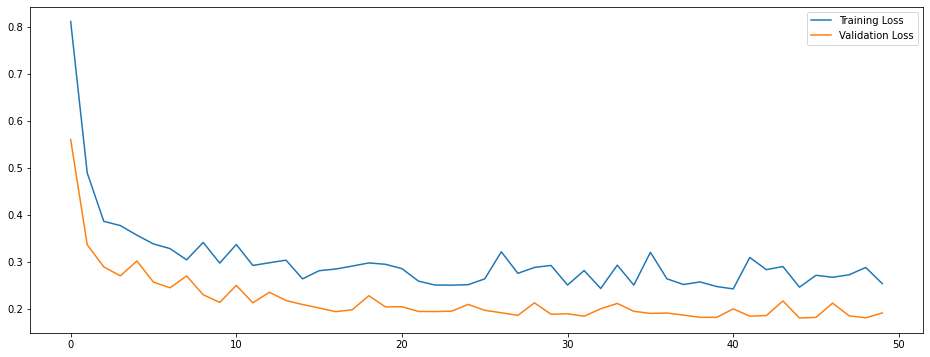

In [12]:
fig = plt.figure(figsize=(16,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
leg = plt.legend()



In [21]:
config_best_traj=preproc_traj.config_optimized_traj()
best_traj_config=best_hps.values
config_best_traj['ordering']=best_traj_config['ordering']
config_best_traj[ 'vd_spiral_arms']=best_traj_config[ 'vd_spiral_arms']
config_best_traj['vd_inner_cutoff']=best_traj_config['vdi']
config_best_traj['pre_vd_outer_cutoff']=best_traj_config['pre_vdo']
config_best_traj['vd_outer_density']=best_traj_config['outer_den']
config_best_traj['vd_type']=best_traj_config['vd_type']

traj_function=preproc_traj.create_traj_fn(**config_best_traj)
preproc_function=preproc_fastdvdnet.preprocessing_fn(**config_preproc)

In [23]:
#Save Configuration
import json
global_config={**config,**config_best_traj,**config_preproc,**config_model}
for key in global_config.keys():
    global_config[key]=str(global_config[key])
filename = os.path.join(exp_dir,'config.json')
with open(filename, 'w') as f:
    f.write(json.dumps(global_config))


{'ordering': 'tiny', 'vd_spiral_arms': 18, 'vdi': 0.27923741114945233, 'pre_vdo': 0.11173513421559131, 'outer_den': 0.28365011341910457, 'vd_type': 'hanning', 'tuner/epochs': 5, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


/home/oj20/anaconda3/envs/hyperslice/lib/python3.9/site-packages/tensorflow_mri/python/ops/traj_ops.py:401: UserWarning: When using tiny golden angle ordering, optimal k-space filling is achieved when the number of views is a member of the generalized Fibonacci sequence: 1, 7, 8, 15, 23, 38, 61, 99, 160, 259..., but the specified number (39) is not a member of this sequence.
  warnings.warn(


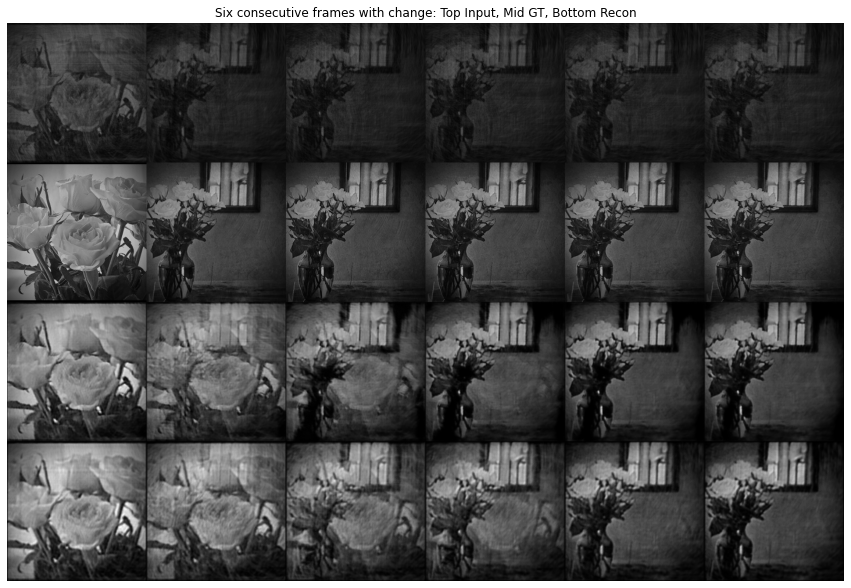

In [26]:
#Inference
#Preproc series 1
print(best_hps.values)
model = tuner.hypermodel.build(best_hps)
model.load_weights(checkpoint_filepath)
kspace=preproc_natural_image(test_files[1])
ds=tf.data.Dataset.from_tensors(kspace)
image=traj_function(ds)
for element in image:
  inputs_temp,gt_temp=preproc_function(element)
#Preproc series 2
kspace2=preproc_natural_image(test_files[2])
ds2=tf.data.Dataset.from_tensors(kspace2)
image2=traj_function(ds2)
for element in image2:
  inputs_temp2,gt_temp2=preproc_function(element)

#Run model on buffered 5 image in a series
inputs=np.concatenate((inputs_temp,inputs_temp2),axis=2)
gts=np.concatenate((gt_temp,gt_temp2),axis=2)
buffer=[]
output=[]
bestoutput=[]
for pp in range(inputs.shape[-1]):
  buffer.append(inputs[:,:,pp])
  if pp>3:
    model_input=np.expand_dims(np.stack(buffer,axis=-1),axis=0)
    output.append(model(model_input))
    bestoutput.append(best_model(model_input))
    buffer=buffer[1:]

output=np.concatenate(output,axis=-1)
bestoutput=np.concatenate(bestoutput,axis=-1)
plot_image=np.concatenate((inputs[:,:,4:],gts[:,:,4:],output[0,...],bestoutput[0,...]),axis=0)

plt.figure(figsize=(15,12))
start_frame=7
plt.imshow(np.abs(np.concatenate((plot_image[:,:,start_frame],plot_image[:,:,start_frame+1],plot_image[:,:,start_frame+2],plot_image[:,:,start_frame+3],plot_image[:,:,start_frame+4],plot_image[:,:,start_frame+5]),axis=1)),cmap='gray')
plt.axis('off')
plt.title('Six consecutive frames with change: Top Input, Mid GT, Bottom Recon')
savefilename=os.path.join(exp_dir,'fig_orientation_change')
plt.savefig(savefilename)

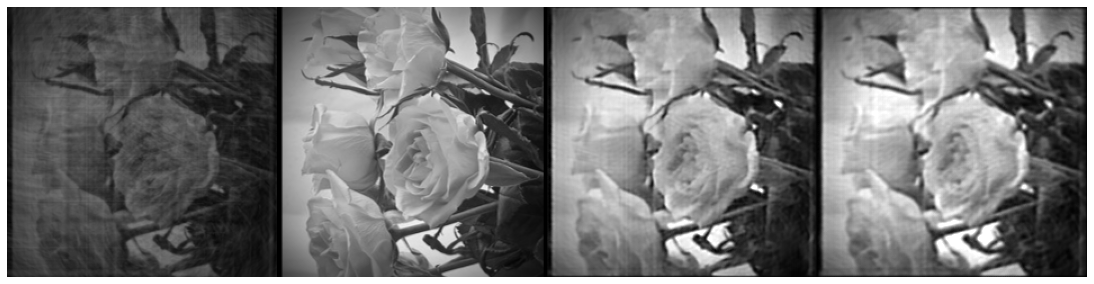

In [25]:
#From Left to Right: Input, Ground Truth, Reconstructed.
savepath=os.path.join(exp_dir,'video_orientation_change')
display_func.plotVid(np.transpose(plot_image,axes=[1,0,2]),interval=55,vmin=0,vmax=1,savepath=savepath)